<a href="https://colab.research.google.com/github/RobertoCalber/DataScienceSeminar/blob/main/Talleres/Taller1/TallerExploratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TALLER – ANÁLISIS EXPLORATORIO DEL DATASET BANCARIO**

Estudiante: Roberto José Calderón Bermejo

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 20)

In [6]:
RUTA_CSV = "dataset_banco.csv"
data = pd.read_csv(RUTA_CSV)

In [3]:
print("Shape (filas, columnas):", data.shape)
data.info()
data.head()
data.describe()

Shape (filas, columnas): (45215, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45215 entries, 0 to 45214
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45215 non-null  int64  
 1   job        45213 non-null  object 
 2   marital    45214 non-null  object 
 3   education  45214 non-null  object 
 4   default    45215 non-null  object 
 5   balance    45213 non-null  float64
 6   housing    45215 non-null  object 
 7   loan       45215 non-null  object 
 8   contact    45215 non-null  object 
 9   day        45215 non-null  int64  
 10  month      45215 non-null  object 
 11  duration   45214 non-null  float64
 12  campaign   45215 non-null  int64  
 13  pdays      45214 non-null  float64
 14  previous   45215 non-null  int64  
 15  poutcome   45215 non-null  object 
 16  y          45215 non-null  object 
dtypes: float64(3), int64(4), object(10)
memory usage: 5.9+ MB


,age,balance,day,duration,campaign,pdays,previous
count,45215.000000,45213.000000,45215.000000,45214.000000,45215.000000,45214.000000,45215.000000
mean,41.004711,1374.159866,15.805839,258.074357,2.763729,40.192485,0.580383
std,12.036647,3924.255525,8.322473,257.605175,3.097910,100.120622,2.303438
min,18.000000,-8019.000000,1.000000,-1389.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,776.000000,527532.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


**Preguntas - Nivel descriptivo**
1. ¿Cuántas observaciones y variables tiene el dataset?

    Tiene 45.215 observaciones y 17 variables.

2. ¿Qué tipos de variables existen (numéricas / categóricas)?

    Existen variables numéricas (7 en total: 4 int64 y 3 float64) y variables categóricas (10 en total, tipo object).

3. ¿Cuál crees que es la variable más importante y por qué?

    La variable más importante es y, porque es la variable objetivo (indica si el cliente se suscribió: yes/no). Todo el análisis busca entender qué factores se relacionan con ese resultado.

4. ¿Qué variables parecen tener escalas muy diferentes?
Se observan escalas muy diferentes principalmente en:

    * balance (mín ≈ -8019, máx ≈ 527532)

    * duration (mín ≈ -1389, máx ≈ 4918)

    * pdays (mín = -1, máx = 871)
    
    También aparece un valor atípico en age (máx = 776).

5. ¿Qué variables podrían requerir transformación?

    Podrían requerir transformación o tratamiento especial:

    * balance, por su alta dispersión y valores extremos.

    * duration, por su rango amplio y presencia de valores atípicos (además de que conceptualmente puede causar data leakage en modelado).

    * pdays, porque incluye -1 (que normalmente representa “no contactado previamente”), lo cual suele tratarse como categoría/flag o con transformación específica.

**Preguntas – Nivel crítico**

6. ¿Qué información no puedes obtener solo con describe()?


    * la distribución de categorías (frecuencias) de variables como job, education, contact, etc.;

    * el grado de desbalance real de la clase objetivo y;

    * la forma de las distribuciones (asimetría, multimodalidad) ni relaciones entre variables;

    * posibles inconsistencias semánticas en categorías (errores de escritura, abreviaturas).

7. ¿Por qué describe() no muestra variables categóricas?

    Porque describe() por defecto resume solo variables numéricas. Para incluir categóricas se debe usar describe(include="object") o analizar con value_counts().

8. ¿Qué variable podría generar problemas si se analiza solo con promedios?

    balance, porque tiene valores extremos muy altos y también negativos; por eso la media puede quedar sesgada y no representar bien al “cliente típico”. En este caso, la mediana y percentiles son más confiables.

In [7]:
# Paso 2: Variable objetivo (sin modelar)
# Ejecuta:
data['y'].value_counts()
data['y'].value_counts(normalize=True)

,proportion
y,
no,0.88
yes,0.12


**Preguntas – Interpretación**

1. ¿Cuál es la clase mayoritaria?

    La clase mayoritaria es “no” (≈ 0.88).

2. ¿Qué porcentaje representa la clase minoritaria?

    La clase minoritaria es “yes” y representa aproximadamente 12% (≈ 0.12).

3. ¿Este comportamiento es realista en campañas bancarias?

    Sí. En campañas bancarias de suscripción (por ejemplo, depósitos a término), normalmente solo una fracción de los clientes acepta la oferta; por eso es común observar una mayoría de “no” y una minoría de “yes”.

4. ¿Qué riesgo existe si ignoramos la clase minoritaria?

    El riesgo es no identificar correctamente a los clientes que sí podrían suscribirse, lo que implica pérdida de oportunidades de conversión y mala asignación de recursos (se optimiza “acertar no”, pero se falla en el objetivo de negocio que es capturar “yes”).

**Preguntas – Pensamiento crítico**

5. ¿Un dataset balanceado siempre representa mejor la realidad?

    No siempre. Un dataset balanceado puede ayudar al entrenamiento de modelos, pero puede distorsionar la distribución real del fenómeno. Lo ideal es representar la realidad y, si el objetivo es detectar la minoría, aplicar técnicas de modelado (ponderación de clases, métricas adecuadas, muestreo) sin alterar la interpretación del contexto real.

6. ¿Qué decisiones del negocio podrían verse afectadas por este desbalance?
   
    Podría afectar decisiones como: a quién contactar, cuánto presupuesto asignar a la campaña, qué segmentos priorizar, y cómo evaluar el desempeño de la estrategia. Si se usa solo accuracy, se podrían tomar decisiones equivocadas creyendo que el modelo es “bueno” aunque no detecte bien los clientes con probabilidad de suscripción.

7. ¿Qué variable podría estar relacionada con la clase “yes”?

    Una variable fuertemente relacionada suele ser duration (duración de la llamada), porque conversaciones más largas tienden a ocurrir cuando hay interés del cliente. También podrían estar relacionadas variables de interacción/campaña como campaign, previous y pdays, que reflejan historial de contacto y persistencia de la campaña.

In [8]:
#PARTE 2 – CALIDAD DE DATOS (35 min)
#Paso 3: Análisis de valores faltantes
#Ejecuta:
data.isnull().sum()

,0
age,0
job,2
marital,1
education,1
default,0
balance,2
housing,0
loan,0
contact,0
day,0


**Preguntas – Técnica**

1. ¿Qué variables tienen valores faltantes?

    job (2), marital (1), education (1), balance (2), duration (1), pdays (1).

2. ¿Qué porcentaje del dataset representan?

    Con 45.215 filas, los faltantes representan porcentajes muy bajos:

    * job: 2/45215 ≈ 0.0044%

    * balance: 2/45215 ≈ 0.0044%

    * marital: 1/45215 ≈ 0.0022%

    * education: 1/45215 ≈ 0.0022%

    * duration: 1/45215 ≈ 0.0022%

    * pdays: 1/45215 ≈ 0.0022%

    En total, son 8 valores faltantes en todo el dataset (≈ 0.0177% de las filas si asumimos que están en filas distintas).

3. ¿Hay variables críticas con datos faltantes?

    No parecen críticas por volumen, porque los faltantes son mínimos. Sin embargo, duration y pdays pueden ser sensibles según el análisis (por su relación con la respuesta y el historial de contacto), pero aquí el problema es marginal porque solo falta 1 dato en cada una.

**Preguntas – Decisión**

4. ¿Eliminarías filas con NA? ¿Por qué?
    
    Sí, en este caso sí eliminaría las filas con NA, porque el porcentaje de faltantes es extremadamente bajo y eliminarlas no afecta de forma significativa la muestra, además de evitar suposiciones innecesarias al imputar.

5. ¿Qué información podrías perder?

    Podrías perder algunos registros que quizá correspondan a clientes con características específicas (por ejemplo, ciertos perfiles laborales o educativos si el NA está concentrado), pero dado que son muy pocos casos, la pérdida de información es prácticamente despreciable.

6. ¿Imputarías todos los NA con la misma técnica?

    No. Depende del tipo de variable:

    * En categóricas (job, marital, education) tendría sentido imputar con la moda o una categoría “unknown”.

    * En numéricas (balance, duration, pdays) sería más razonable usar mediana (más robusta a outliers) o un criterio específico del significado de la variable (por ejemplo, pdays suele tener codificaciones especiales).

**Preguntas – Ética y sesgo**

7. ¿Eliminar NA podría introducir sesgo?

    Sí, podría introducir sesgo si los faltantes no son aleatorios (por ejemplo, si faltan más datos en un grupo específico de clientes). En este caso el riesgo existe en teoría, pero es muy bajo por la cantidad mínima de faltantes.

8. ¿Qué tipo de clientes podrían quedar fuera del análisis?

    Potencialmente, clientes asociados a las variables con NA: perfiles donde falte ocupación (job), estado civil (marital), educación (education), o registros con información incompleta de saldo (balance) o de contacto (duration, pdays). Aun así, serían muy pocos.

9. ¿Esto afectaría la representatividad del dataset?

    En la práctica, no de forma relevante, porque la proporción de datos eliminados por NA es casi nula frente al total (del orden de centésimas de porcentaje).

In [9]:
#Paso 4: Análisis de duplicados
#Ejecuta:
data.duplicated().sum()

np.int64(4)

**Preguntas:**

1. ¿Existen duplicados?

    Sí. Se detectan 4 registros duplicados.

2. ¿Un duplicado siempre es un error?

    No necesariamente. Puede ser un error de captura o integración de datos, pero también podría representar eventos reales repetidos (por ejemplo, un mismo cliente contactado varias veces) si el dataset no incluye un identificador único por cliente o por interacción.

3. ¿Qué información adicional necesitarías para decidir?

    Necesitaría saber si existe un ID único (del cliente o de la llamada), y la definición de “registro” en el dataset: si cada fila es un cliente único o si cada fila es una interacción/campaña. También sería útil conocer el proceso de recolección (si se consolidaron fuentes) y revisar si los duplicados coinciden en todas las columnas o solo en un subconjunto.

4. ¿Qué pasaría si eliminamos registros válidos?

    Se podría introducir sesgo y pérdida de información: por ejemplo, subestimar la frecuencia real de ciertos perfiles o resultados, alterar la distribución de la variable objetivo y, y afectar métricas o patrones (especialmente si los duplicados se concentran en una clase o segmento). En general, eliminar registros válidos reduce la representatividad y puede distorsionar conclusiones.

<Axes: xlabel='balance'>

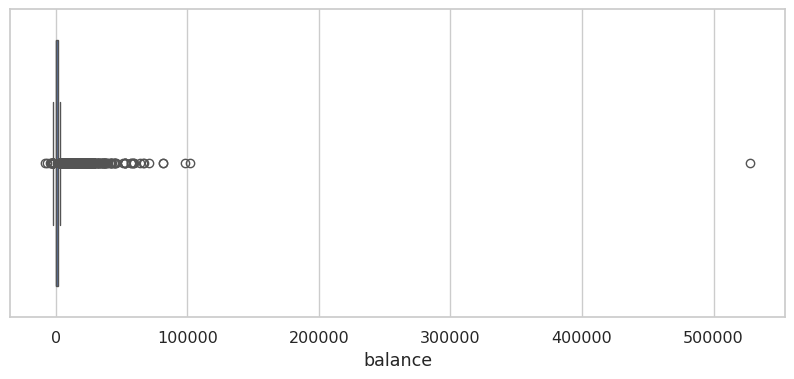

In [10]:
#Paso 5: Análisis de outliers
#Ejecuta:
import seaborn as sns
sns.boxplot(x=data['balance'])

**Preguntas – Observación**

1. ¿Existen valores extremos?

    Sí. El boxplot de balance muestra una gran cantidad de valores alejados del rango central, incluyendo puntos extremadamente altos.

2. ¿Son positivos, negativos o ambos?

    Son ambos: hay balances negativos (por debajo de cero) y balances positivos muy altos (se observa al menos un caso cercano a 500.000+).

3. ¿El boxplot te permite ver todos los detalles?

    No completamente. El boxplot resume la distribución (mediana, cuartiles y outliers), pero cuando hay muchos valores extremos, el gráfico pierde detalle en la zona central porque queda “comprimida”. Para ver mejor los detalles se requerirían histogramas, zoom, escala logarítmica o análisis por percentiles.

**Preguntas – Estadística**

4. ¿Cómo afectan los outliers a la media?

    La media se desplaza hacia los valores extremos (especialmente hacia los positivos muy altos), quedando sesgada y representando peor al cliente típico.

5. ¿La mediana se ve afectada?

    Mucho menos. La mediana es robusta frente a outliers porque depende del orden de los datos y no de la magnitud de valores extremos.

6. ¿Qué estadístico sería más confiable aquí?

    La mediana y los percentiles (por ejemplo, P25–P75, P5–P95) son más confiables que la media para describir el comportamiento típico de balance.

**Preguntas – Decisión**

7. ¿Eliminarías los outliers? Justifica.

    No los eliminaría automáticamente. Primero validaría si corresponden a clientes reales (por ejemplo, cuentas con alto saldo) o a errores de captura. Si el objetivo es modelar sin que dominen los extremos, preferiría transformaciones (log/robust scaling), o winsorización controlada, en lugar de borrar datos sin criterio.

8. ¿Podrían representar clientes reales?

    Sí. En un contexto bancario es razonable que existan clientes con saldos muy altos y también clientes con sobregiros o deudas (saldos negativos).

9. ¿Qué riesgos existen al eliminarlos sin análisis?

    Se corre el riesgo de:

      * eliminar clientes de alto valor o perfiles relevantes,

    * introducir sesgo y perder representatividad,

    * distorsionar relaciones entre variables (y la clase y),

    *  obtener conclusiones o modelos poco aplicables al mundo real.

### **ACTIVIDAD DE DISCUSIÓN FINAL**

**Eje 1 – Datos vs Decisiones**

* ¿Qué decisiones de limpieza son más riesgosas?

    Las más riesgosas son las que pueden cambiar el significado real del fenómeno. En este dataset, lo más delicado sería eliminar outliers de balance sin validación, porque en un banco los saldos extremos pueden corresponder a clientes reales de alto valor o a sobregiros. También es riesgoso eliminar duplicados automáticamente sin saber si una fila representa un cliente único o una interacción; si cada registro es una llamada, un “duplicado” podría ser un evento legítimo. En contraste, eliminar filas con NA aquí es menos riesgoso porque los faltantes son mínimos (solo 8 valores en total distribuidos en pocas columnas).

* ¿Qué errores podrían afectar un modelo futuro?

    Hay tres errores clave:

    * Data leakage: usar variables que no están disponibles en el momento de decisión. El caso típico es duration, porque se conoce después de la llamada; incluirla puede inflar el desempeño y dar un modelo poco aplicable.

    * No tratar el desbalance de clases: como y está muy desbalanceada (~88% “no”, ~12% “yes”), un modelo puede lograr alta accuracy prediciendo casi siempre “no” y fallar en detectar “yes”, que es la clase de interés.

    * Escalas y outliers sin tratamiento: variables como balance tienen rangos enormes, lo cual afecta modelos sensibles a escala y puede sesgar métricas descriptivas.

**Eje 2 – Estadística vs Realidad**

* ¿Los outliers siempre son errores?

    No. En este contexto, los outliers pueden ser clientes reales: algunos con saldos muy altos y otros con saldos negativos por deudas o sobregiros. Por eso, antes de eliminarlos, habría que confirmar si provienen de errores de captura o si son casos válidos. Si se eliminan sin criterio, se puede perder información valiosa y sesgar el análisis.

* ¿La media es una buena medida para balance?

    No es la mejor. Como balance tiene valores extremos muy grandes, la media se arrastra hacia esos valores y deja de representar al cliente típico. En este caso, la mediana y percentiles son más confiables para describir el comportamiento central. La media puede usarse, pero debe acompañarse de medidas robustas y de una visualización que muestre la asimetría.

**Eje 3 – Preparación para el futuro**

* ¿Qué información adicional pedirías antes de modelar?

  Pediría principalmente:

  * Definición exacta del registro: si cada fila es un cliente o una interacción (llamada).

  * Un identificador de cliente (si existe) para manejar repetidos correctamente.

  * Contexto temporal de la campaña: si hay estacionalidad por month o cambios de estrategia.

  * Confirmación del significado de variables especiales como pdays = -1, que suele representar “no contactado previamente”.

* ¿Qué variable analizarías más a fondo?

  Analizaría más a fondo duration, por dos razones: es muy predictiva, pero puede ser data leakage. Haría dos análisis:

    * Evaluar qué tanto mejora resultados con duration vs sin duration.

    * Definir si el objetivo del modelo es antes de llamar (entonces se excluye) o durante la llamada (podría tener sentido).
    También profundizaría en pdays, previous y campaign porque reflejan historial de contacto y pueden conectar directamente con la probabilidad de “yes”.